In [ ]:
import sys
import os

# Go up to project root (from inside training/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from core.models.hierarchical_transformer_prototype import HierarchicalTransformer
import gc
import random
# Training
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
def initial_cleanup():
    # Memory cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()
    
    # Set random seeds
    random.seed(69)
    np.random.seed(69)
    torch.manual_seed(69)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(69)
        torch.cuda.manual_seed_all(69)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print("Clean slate initialized!")

# Call this at the top of your notebook
initial_cleanup()

Clean slate initialized!


In [ ]:
# Load data
data = np.load('../../data/keypoints/deadlifts_squats_shoulder_press_2025-06-20.npz')
X = data['X'][:, :, :, :3] 
y = data['y']
print(X.shape, y.shape)

(1992, 378, 33, 3) (1992,)


## Training the model

In [ ]:
data = np.load('../../data/keypoints/deadlifts_squats_shoulder_press_2025-06-03.npz')
X = data['X'][:, :, :, :3]  # drop visibility
y = data['y']

# Convert to PyTorch tensors
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).long()


X_temp, X_test, y_temp, y_test = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=69)

val_ratio = 0.1 / 0.9  # ≈ 0.1111 of remaining
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=69)

# Create dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [14]:
torch.unique(y_tensor)

tensor([0, 1, 2])

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HierarchicalTransformer(
    num_joints=33,
    num_frames=378,
    d_model=64,
    dim_feedforward=512,
    nhead=4,
    num_spatial_layers=1,
    num_temporal_layers=1,
    num_classes=len(torch.unique(y_tensor))
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 64
train_loss_history = []
val_loss_history = []

train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        print("DEBUG: ")
        print("Output: ", outputs.shape)
        print("Y: ", y_batch.shape)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/64 | Train Loss: 1.1054, Acc: 0.3653 | Val Loss: 1.0774, Acc: 0.4118
Epoch 2/64 | Train Loss: 1.0841, Acc: 0.3998 | Val Loss: 1.0651, Acc: 0.4363
Epoch 3/64 | Train Loss: 1.0561, Acc: 0.4742 | Val Loss: 1.0111, Acc: 0.4167
Epoch 4/64 | Train Loss: 0.9530, Acc: 0.5800 | Val Loss: 0.8083, Acc: 0.7451
Epoch 5/64 | Train Loss: 0.7716, Acc: 0.7472 | Val Loss: 0.6272, Acc: 0.9167
Epoch 6/64 | Train Loss: 0.6301, Acc: 0.8413 | Val Loss: 0.5318, Acc: 0.8333
Epoch 7/64 | Train Loss: 0.5391, Acc: 0.9010 | Val Loss: 0.4522, Acc: 0.8873
Epoch 8/64 | Train Loss: 0.4717, Acc: 0.9010 | Val Loss: 0.4004, Acc: 0.9167
Epoch 9/64 | Train Loss: 0.4206, Acc: 0.9176 | Val Loss: 0.3663, Acc: 0.9216
Epoch 10/64 | Train Loss: 0.3934, Acc: 0.9164 | Val Loss: 0.3714, Acc: 0.9069
Epoch 11/64 | Train Loss: 0.3511, Acc: 0.9244 | Val Loss: 0.3137, Acc: 0.9314
Epoch 12/64 | Train Loss: 0.3254, Acc: 0.9293 | Val Loss: 0.3169, Acc: 0.9118
Epoch 13/64 | Train Loss: 0.2987, Acc: 0.9311 | Val Loss: 0.2808, Acc: 0.

In [ ]:
# save
torch.save(model.state_dict(), '../../models/hierarchical transformer/hierarchical_transformer_weights_2025-06-20_small_1.pth')

In [ ]:
# Switch to eval mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['squats', 'deadlifts', "shoulder_press"])  # replace with your actual class names
print(report)

                precision    recall  f1-score   support

        squats       0.95      1.00      0.97        52
     deadlifts       1.00      0.98      0.99        60
shoulder_press       1.00      0.98      0.99        92

      accuracy                           0.99       204
     macro avg       0.98      0.99      0.98       204
  weighted avg       0.99      0.99      0.99       204



In [ ]:
matrix = confusion_matrix(all_labels, all_preds)
print(matrix)

[[52  0  0]
 [ 1 59  0]
 [ 2  0 90]]


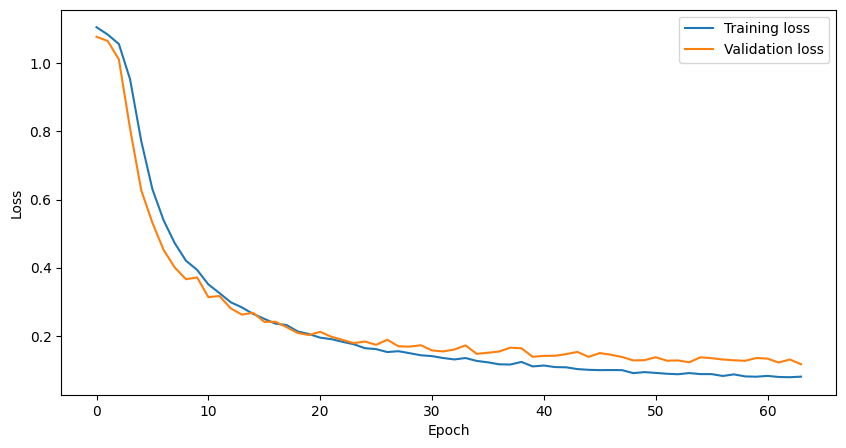

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

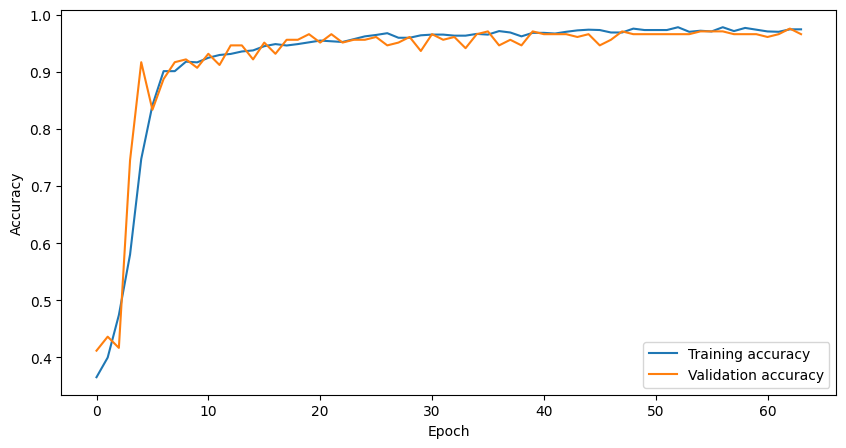

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training accuracy')
plt.plot(val_acc_history, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()